Saving 202501_04_clean.xlsx to 202501_04_clean (7).xlsx


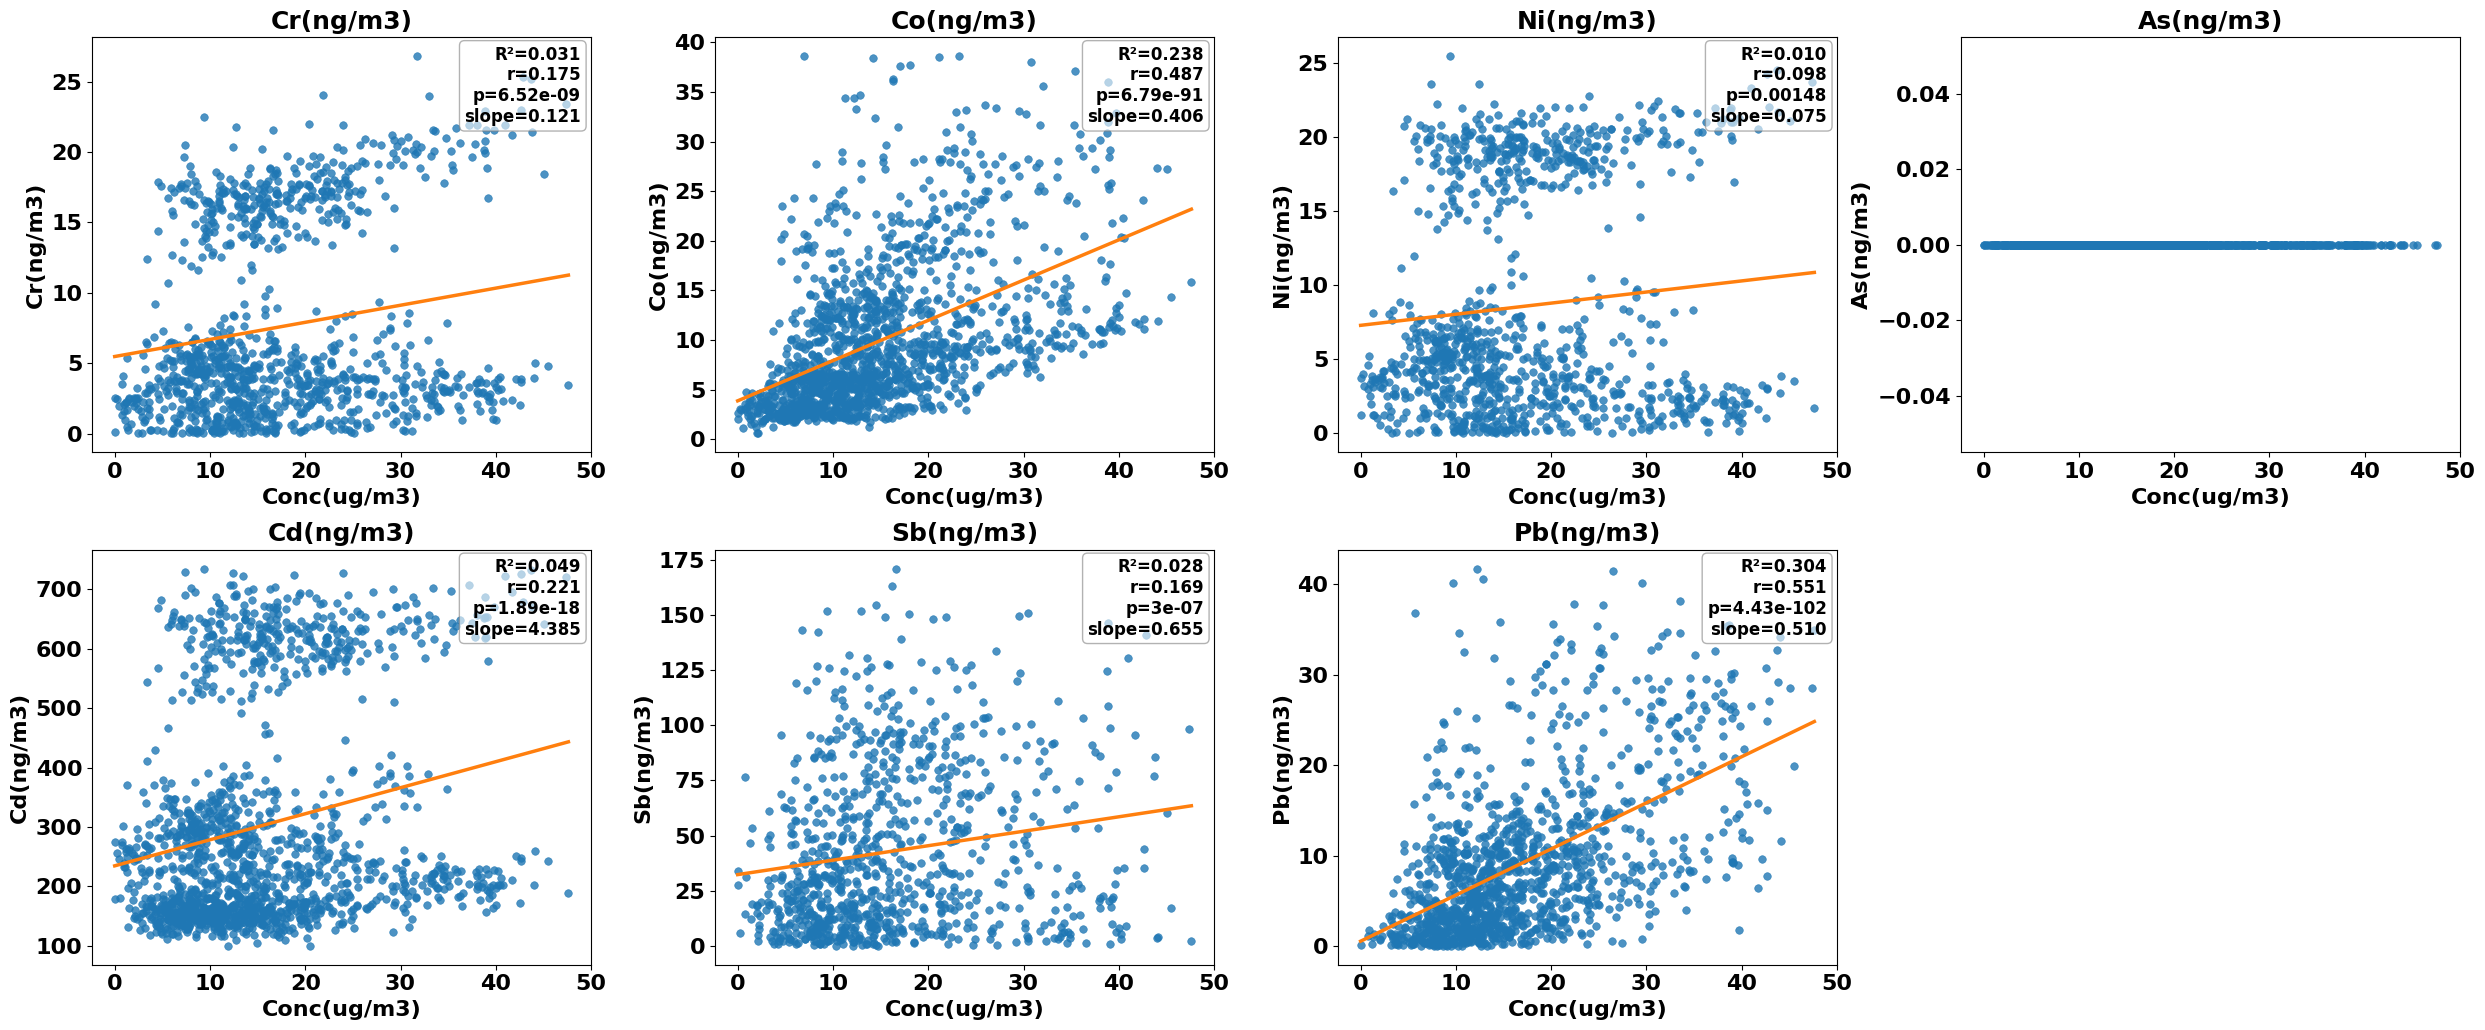

In [13]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from google.colab import files   # Colab에서 업로드 시 필요

# ===== 파일 업로드 =====
uploaded = files.upload()
fname = next(iter(uploaded.keys()))
df = pd.read_excel(fname)

# ===== 분석 대상 컬럼 추출 =====
unit_patterns = ['(ng/m3)', '(ug/m3)', '(µg/m³)', '(μg/m3)']
columns_to_analyze = [c for c in df.columns if any(p in str(c) for p in unit_patterns)]

# X축 후보
x_candidates = ['Conc(ug/m3)', 'PM2.5(ug/m3)', 'PM2.5 (ug/m3)', 'Con(ug/m3)']
xcol = next((c for c in x_candidates if c in df.columns), None)
if xcol is None:
    raise ValueError("X-axis column not found. Check the actual column name for PM2.5 mass.")

# Y축 후보
ycols = [c for c in columns_to_analyze if c != xcol]
if len(ycols) == 0:
    raise ValueError("No Y columns to plot. Check filter logic.")

# ===== 데이터 클린 함수 =====
def clean_series(s: pd.Series) -> pd.Series:
    s_num = pd.to_numeric(s, errors='coerce')
    return s_num.mask(s_num < 0)

# ===== 전역 스타일 =====
TITLE_FT = 18   # subplot 제목
LABEL_FT = 16   # 축 라벨
TICK_FT  = 16   # 축 숫자
ANN_FT   = 12   # 주석 폰트

plt.rcParams.update({
    "axes.titlesize": TITLE_FT,
    "axes.titleweight": "bold",
    "axes.labelsize": LABEL_FT,
    "axes.labelweight": "bold",
    "xtick.labelsize": TICK_FT,
    "ytick.labelsize": TICK_FT
})

# ===== 산점도 + 회귀 함수 =====
def plot_scatter_with_regression(x: str, y: str, data: pd.DataFrame, ax):
    title = f"{y}"
    x_ser = clean_series(data[x])
    y_ser = clean_series(data[y])
    df_xy = pd.concat([x_ser.rename(x), y_ser.rename(y)], axis=1).dropna()

    # 예외 처리
    if len(df_xy) < 3 or df_xy[x].std() == 0 or df_xy[y].std() == 0:
        sns.scatterplot(data=df_xy, x=x, y=y, ax=ax, s=30, alpha=0.8, edgecolor=None)
        ax.set_xlabel(x, fontweight='bold'); ax.set_ylabel(y, fontweight='bold')
        ax.set_title(title, fontweight='bold')
        # 축 숫자 크기/볼드
        ax.tick_params(axis='both', which='both', labelsize=TICK_FT)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(TICK_FT)
            label.set_fontweight('bold')
        return None

    # 산점도
    sns.scatterplot(data=df_xy, x=x, y=y, ax=ax, s=30, alpha=0.8, edgecolor=None)

    # 선형 회귀
    X_vals = df_xy[[x]].to_numpy()
    y_vals = df_xy[y].to_numpy()
    model = LinearRegression().fit(X_vals, y_vals)
    y_pred = model.predict(X_vals)
    r2 = float(model.score(X_vals, y_vals))
    slope = float(model.coef_[0])
    r, p = pearsonr(df_xy[x].to_numpy(), df_xy[y].to_numpy())

    # 회귀선
    order = np.argsort(X_vals.ravel())
    ax.plot(X_vals.ravel()[order], y_pred[order], linewidth=2.5, color='C1')

    # 라벨/제목
    ax.set_xlabel(x, fontsize=LABEL_FT, fontweight='bold')
    ax.set_ylabel(y, fontsize=LABEL_FT, fontweight='bold')
    ax.set_title(title, fontsize=TITLE_FT, fontweight='bold')

    # 축 숫자 크기/볼드
    ax.tick_params(axis='both', which='both', labelsize=TICK_FT)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(TICK_FT)
        label.set_fontweight('bold')

    # 라벨/제목
    ax.set_xlabel(x, fontsize=LABEL_FT, fontweight='bold')
    ax.set_ylabel(y, fontsize=LABEL_FT, fontweight='bold')
    ax.set_title(title, fontsize=TITLE_FT, fontweight='bold')

    # 축 숫자 크기/볼드
    ax.tick_params(axis='both', which='both', labelsize=TICK_FT)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(TICK_FT)
        label.set_fontweight('bold')

    # 주석 박스
    note = (f"R²={r2:.3f}\nr={r:.3f}\np={p:.3g}\n"
            f"slope={slope:.3f}")
    ax.text(0.98, 0.98, note, transform=ax.transAxes,
            ha='right', va='top',
            fontsize=ANN_FT, fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='0.5',
                      boxstyle='round,pad=0.3', alpha=0.6))

# ===== 서브플롯 배치 =====
n = len(ycols)
ncols = 4
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(6.2*ncols, 5.2*nrows))
axes = np.atleast_1d(axes).ravel()

# 여백 조정
fig.subplots_adjust(right=0.96, wspace=0.40, hspace=0.55)

# 플롯 생성
for i, metal in enumerate(ycols):
    plot_scatter_with_regression(xcol, metal, df, axes[i])

# 남는 축 숨김
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()